<a href="https://colab.research.google.com/github/ypeng22/DLFinal/blob/main/image_cnn_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
## Mount Google Drive Data (If using Google Colaboratory)
try:
    from google.colab import drive
    drive.mount('/content/gdrive')
except:
    print("Mounting Failed.")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [34]:
data_dir = "/content/gdrive/MyDrive/rgb_video_data"

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 240, 180])


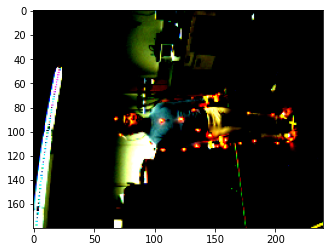

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.models import resnet101
import random

subjects = ['S01', 'S02', 'S03', 'S04', 'S05','S06', 'S07', 'S08', 'S09', 'S10', 'S11', 'S12']
actions = ['A01', 'A02', 'A03', 'A04', 'A05','A06', 'A07', 'A08', 'A09', 'A10', 'A11']
reps = ['R01', 'R02', 'R03', 'R04', 'R05']

class BerkeleyMHAD(Dataset):

    def __init__(self, vid_names, root_dir, classes, transform=None):
        self.vid_names = vid_names # list of file names for videos (ex. S01_A01_R01)
        self.root_dir = root_dir # directory where videos are stored
        self.transform = transform
        self.classes = classes
        
    def __len__(self):
        return len(self.vid_names)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        path = os.path.join(self.root_dir, self.vid_names[idx])
        x = np.load(path)['x']
        
        data = []
        if self.transform:
            for i in range(x.shape[0]):
                data.append(self.transform(x[i]))
        
        vid_tensor = torch.stack(data)
        label = self.classes.index(np.load(path)['y']) 
        sample = {'x': vid_tensor, 'y': label}

        return sample
    
class cnn_lstm(nn.Module):
    def __init__(self, classes):
        super(cnn_lstm, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.pool1 = nn.MaxPool2d(3)
        self.n_hidden = 256
        self.n_layers = 3
        self.l_lstm = torch.nn.LSTM(input_size = 300, 
                                 hidden_size = self.n_hidden,
                                 num_layers = self.n_layers, 
                                 batch_first = True)
        self.fc1 = nn.Linear(1000, 300)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, classes)
        #self.relu = nn.LeakyReLU(.1)
        self.relu = nn.ReLU()

        self._initialize_weights()
        self.resnet = resnet101(pretrained=True)
        #self.soft = nn.Softmax(dim = 0)

    def forward(self, x):
        batch = x.shape[0]
        #intialize lstm hidden state
        hidden_state = torch.zeros(self.n_layers, 1, self.n_hidden).to(dev)
        cell_state = torch.zeros(self.n_layers, 1, self.n_hidden).to(dev)
        #hidden_state = torch.randn(self.n_layers, 1, self.n_hidden).to(dev)
        #cell_state = torch.randn(self.n_layers, 1, self.n_hidden).to(dev)
        self.hidden = (hidden_state, cell_state)
        
        #x = self.pool1(self.relu(self.conv1(x)))
        #x = self.pool1(self.relu(self.conv2(x)))
        #x = self.pool1(self.relu(self.conv3(x)))
        with torch.no_grad():
            x = self.resnet(x)

        #print(x.shape)
        x = x.reshape(batch, -1).unsqueeze(0)
        x = self.fc1(x)
        lstm_out, _ = self.l_lstm(x, self.hidden) #lstm_out shape is batch_size, seq len, hidden state
        lstm_out = lstm_out[:,-1,:]
        lstm_out = self.relu(self.fc2(lstm_out.squeeze()))
        lstm_out = (self.fc3(lstm_out))
        #print(lstm_out.shape)
        #lstm_out = self.soft(lstm_out)
        return lstm_out

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out',
                                        nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out',
                                        nonlinearity='relu')
                nn.init.constant_(m.bias, 0)
    
def check(i):
    #insert more i.find terms for each action
    return i.find('A01') != -1 or i.find('A07') != -1 or i.find('A03') != -1 or i.find('A010') != -1
#vid_names = [i for i in next(os.walk(data_dir))[2] if check(i)]

vid_names = os.listdir(data_dir)
train_vid_names = [i for i in vid_names if i.find('S09') == -1 and i.find('S10') == -1 and i.find('S11') == -1 and i.find('S12') == -1]
valid_vid_names = [i for i in vid_names if i.find('S09') != -1 ]
test_vid_names = [i for i in vid_names if i.find('S10') != -1 or i.find('S11') != -1 or i.find('S12') != -1]

#data shape is (num_pics, height, width, channel)
Normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
train_dataset = BerkeleyMHAD(train_vid_names, data_dir, classes = np.arange(0, 11).tolist(), transform=transforms.Compose([transforms.ToTensor(), Normalize]))
valid_dataset = BerkeleyMHAD(valid_vid_names, data_dir, classes = np.arange(0, 11).tolist(), transform=transforms.Compose([transforms.ToTensor(), Normalize]))
test_dataset = BerkeleyMHAD(test_vid_names, data_dir, classes = np.arange(0, 11).tolist(), transform=transforms.Compose([transforms.ToTensor(), Normalize]))
plt.imshow(np.transpose(train_dataset[0]['x'][0]))
print(train_dataset[0]['x'][0].shape)

batch_size = 1

dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#change 2 to number of classes

In [48]:
model = cnn_lstm(11).to(dev)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()
epoch = 10
#train
shuffled = np.arange(len(train_dataset))

tguess = []
tanswers = []
tcorrect = 0
ttotal = 0
for t in range(epoch):
    train_loss = 0
    valid_loss = 0
    tguess = []
    tanswers = []
    tcorrect = 0
    ttotal = 0
    random.shuffle(shuffled)

    for i in range(len(train_dataset)):
        optimizer.zero_grad()

        data = train_dataset[shuffled[i]]
        inpt = data['x'].to(dev)
        label = torch.tensor(data['y']).unsqueeze(0).to(dev)
        output = model(inpt).unsqueeze(0)
        loss = criterion(output, label) #.view(-1)
        loss.backward()
        #grads = []
        #for param in model.parameters():
        #    if param.grad is not None:
        #        grads.append(param.grad.view(-1))
        
        #grads = torch.cat(grads)
        #print(torch.sum(grads))
        #print(torch.norm(grads))
        optimizer.step()  
        #optimizer.zero_grad()
        train_loss += loss.item()
        
        if torch.argmax(output.squeeze()) == label:
            tcorrect += 1
        ttotal += 1
        tanswers.append(label.item())
        #tguess.append(output[0][1].item())
        tguess.append(torch.argmax(output.squeeze()))
        
    grads = []
    for param in model.parameters():
        if param.grad is not None:
            grads.append(param.grad.view(-1))
        
    grads = torch.cat(grads)
    print(torch.norm(grads))
    
    torch.cuda.empty_cache()   

    with torch.no_grad():
        for i in range(len(valid_dataset)):
            data = valid_dataset[i]
            inpt = data['x'].to(dev)
            label = torch.tensor(data['y']).unsqueeze(0).to(dev)
            output = model(inpt).unsqueeze(0)
            loss = criterion(output, label)
            valid_loss += loss.item()
    print("epoch:", valid_loss / len(valid_dataset), train_loss / len(train_dataset))
    if t % 5 == 0:
        torch.save(model.state_dict(), '/content/gdrive/MyDrive/cnn_lstm_epoch_' + str(t) + '_state_dict.pt')



tensor(9.7528e-05, device='cuda:0')
epoch: 1.8237866540295231 0.09445890326552842
tensor(0.0024, device='cuda:0')
epoch: 1.7002018166489672 0.0027241062206988815
tensor(0.0137, device='cuda:0')
epoch: 1.6936588227317935 0.0004574348591399977
tensor(0.0115, device='cuda:0')
epoch: 1.680925829712115 0.0002736099190695755
tensor(0.0037, device='cuda:0')
epoch: 1.6865998418223171 0.00019145629996717824
tensor(0.0095, device='cuda:0')
epoch: 1.6949399438898167 0.00013891069316691423
tensor(0.0016, device='cuda:0')
epoch: 1.71181846299172 0.00010306097094017866
tensor(0.0003, device='cuda:0')
epoch: 1.7298420702924473 7.734914358258647e-05
tensor(0.0028, device='cuda:0')
epoch: 1.7474399285539055 5.8551658773914965e-05
tensor(9.3451e-05, device='cuda:0')
epoch: 1.765515011213285 4.484907710777859e-05


In [49]:
guess = []
answers = []
correct = 0
total = 0
with torch.no_grad():
    for i in range(len(test_dataset)):
        data = test_dataset[i]
        inpt = data['x'].to(dev)
        label = torch.tensor(data['y']).to(dev)
        output2 = model(inpt)
        if torch.argmax(output2.squeeze()) == label:
            correct += 1
        total += 1
        answers.append(label.item())
        guess.append(output2[1].item())
#guess = torch.argmax(guess.squeeze(), dim=1)
#guess = np.array(guess).squeeze()
print("train accuracy = " + str(tcorrect / ttotal))
print("test accuracy = " + str(correct / total))
#print('CNN AUC: %.4f' % roc_auc_score(testlabel, guess), ' AUPRC: %.4f' % average_precision_score(testlabel, guess))
#torch.save(model, '/content/gdrive/MyDrive/cnn_lstm.torch')

train accuracy = 1.0
test accuracy = 0.6535947712418301
